In [ ]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import numpy as np
import ipywidgets as widgets
from matplotlib import pyplot as plt
from topic import ScrollingCorpus
from elastic import elasticsearch_client
import re


In [ ]:

client = elasticsearch_client("../credentials.json", "../http_ca.crt")
index_name = "test-index"
corpus = ScrollingCorpus(client, index_name, "../counts.dict", "../phrase_model.pkl")

In [14]:
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.ldamodel import LdaModel

#lda = LdaMulticore(corpus, id2word=corpus.dictionary, num_topics=7, workers=6)
lda = LdaModel(corpus, id2word=corpus.dictionary, num_topics=6, alpha="auto", eta="auto")
lda.save("lda.model")

In [22]:
def topic_to_words(topic: tuple) -> list:
    find = re.findall(r"\"(\w+)\"", topic)
    return find

topic_words = []

for i, topic in enumerate(lda.print_topics()):
    print(topic)
    topic_words.append(topic_to_words(topic[1]))

print(topic_words)

(0, '0.028*"cystic_fibrosis" + 0.026*"patients" + 0.010*"cf" + 0.008*"children" + 0.007*"disease" + 0.006*"normal" + 0.004*"treatment" + 0.004*"clinical" + 0.004*"patient" + 0.004*"serum"')
(1, '0.024*"patients" + 0.021*"cystic_fibrosis" + 0.010*"children" + 0.010*"cf" + 0.007*"normal" + 0.006*"disease" + 0.006*"serum" + 0.004*"cells" + 0.003*"increased" + 0.003*"concentrations"')
(2, '0.021*"cf" + 0.012*"patients" + 0.011*"cystic_fibrosis" + 0.006*"normal" + 0.005*"activity" + 0.005*"serum" + 0.005*"children" + 0.004*"test" + 0.004*"cells" + 0.003*"increased"')
(3, '0.028*"cf" + 0.024*"patients" + 0.022*"cystic_fibrosis" + 0.006*"serum" + 0.006*"normal" + 0.004*"activity" + 0.004*"disease" + 0.004*"protein" + 0.004*"children" + 0.004*"observed"')
(4, '0.015*"cystic_fibrosis" + 0.013*"cf" + 0.010*"patients" + 0.009*"children" + 0.004*"cases" + 0.004*"normal" + 0.004*"group" + 0.003*"pancreatic" + 0.003*"control" + 0.003*"patient"')
(5, '0.027*"cystic_fibrosis" + 0.022*"patients" + 0.00

In [16]:
topic_matrix = []

for doc in corpus:
    topic_vector = lda.get_document_topics(doc, minimum_probability=0)
    topic_vector = np.array([prob for _, prob in topic_vector])
    topic_matrix.append(topic_vector)

topic_matrix = np.array(topic_matrix)
print(topic_matrix)

[[0.00386317 0.00395402 0.00287218 0.98241824 0.00283963 0.00405279]
 [0.00283926 0.00288503 0.11795579 0.63008326 0.24324225 0.00299444]
 [0.00196902 0.00199888 0.00146514 0.00201487 0.990488   0.00206404]
 ...
 [0.00182723 0.00186376 0.00136609 0.00187731 0.9911386  0.00192705]
 [0.19763763 0.0056269  0.0041005  0.7827688  0.00405    0.0058162 ]
 [0.00263513 0.00269705 0.00196781 0.00270681 0.98721635 0.00277686]]


Clustering time

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

best = [0, 0, None]

for n in range(2, 15):
    clustering_model = KMeans(n_clusters = n)
    clustering_model.fit(topic_matrix)
    #Evaluate clustering:
    score = silhouette_score(topic_matrix, clustering_model.labels_)

    if score > best[0]:
        best[0] = score
        best[1] = n
        best[2] = clustering_model

    print(score)

clustering_model = best[2]

print(f"Best score: {best[0]} ({best[1]} clusters)")
print(best[2].labels_)

0.30384794
0.43206802
0.5637359
0.5704427
0.71226156
0.6945826
0.67612463
0.68890905
0.6667464
0.685316
0.683113
0.70193493
0.7094952
Best score: 0.7122615575790405 (6 clusters)
[3 3 5 ... 5 3 5]


Visualize best model

[[-0.30641377  0.7838772 ]
 [-0.20738852  0.49535862]
 [-0.0309227  -0.02166473]
 ...
 [-0.0309316  -0.02167053]
 [-0.32481462  0.52803683]
 [-0.03084103 -0.02161901]]
[0.71226156, 6, KMeans(n_clusters=6)]


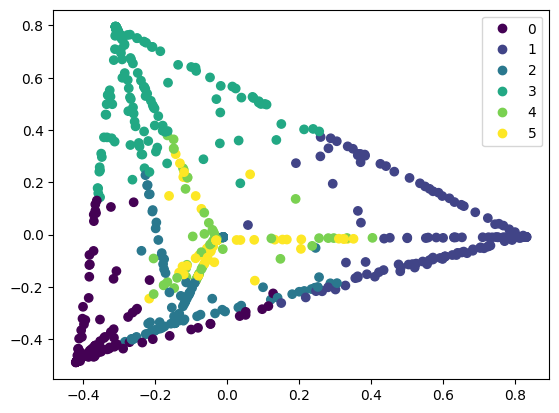

In [18]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

pca = PCA(n_components=2)
reduced = pca.fit_transform(topic_matrix)
print(reduced)

fig, ax = plt.subplots()
print(best)

scatter = ax.scatter(reduced[:, 0], reduced[:, 1], c = best[2].labels_)

ax.legend(*scatter.legend_elements())

Cluster centers

In [19]:
print(clustering_model.cluster_centers_)

strong_topics = {}

for i, center in enumerate(clustering_model.cluster_centers_):
    for j, topic in enumerate(center):
        if topic > 0.7:
            strong_topics[i] = j
            print(f"Cluster {i:02} has strong topic {j:02} ({topic})")

print(strong_topics)

[[0.8930886  0.03057657 0.01021229 0.03329282 0.00991093 0.02291876]
 [0.02305433 0.03910431 0.01656327 0.04192795 0.00781157 0.87153864]
 [0.04549806 0.8103335  0.02726269 0.04262203 0.02761685 0.04666689]
 [0.03522334 0.03379926 0.01647151 0.8596666  0.01680579 0.03803341]
 [0.03736299 0.04282412 0.8195769  0.04344214 0.02229781 0.03449605]
 [0.02650255 0.03301755 0.00753757 0.02823429 0.8626597  0.04204838]]
Cluster 00 has strong topic 00 (0.8930885791778564)
Cluster 01 has strong topic 05 (0.8715386390686035)
Cluster 02 has strong topic 01 (0.8103334903717041)
Cluster 03 has strong topic 03 (0.8596665859222412)
Cluster 04 has strong topic 02 (0.8195769190788269)
Cluster 05 has strong topic 04 (0.8626596927642822)
{0: 0, 1: 5, 2: 1, 3: 3, 4: 2, 5: 4}


We observe that each cluster essentially corresponds to one topic

A topic that is strong for that particular cluster

Let's take one of the clusters and the topic, and see if they are related

In [20]:
clusters = [[] for _ in range(len(clustering_model.labels_))]

for i, label in enumerate(clustering_model.labels_):
    clusters[label].append(i+1)

cluster_test = 0

print(f"Here are the docs for cluster {cluster_test}:")
print(clusters[cluster_test])

print(f"\nTopic of cluster {cluster_test}:")
print(topic_words[strong_topics[cluster_test]])

print()

#Let's see what elasticsearch has to say
def get_doc_keywords(doc: int, minor: bool = True) -> list[str]:
    resp = client.get(index=index_name, id=f"{doc:05}", filter_path="_source.major_subjects,_source.minor_subjects")
    resp = resp["_source"]
    resp = resp["major_subjects"] + resp["minor_subjects"]
    return list(map(lambda kword: re.match(r"([\w\s]+)(:.+)?", kword).group(1), resp))

for doc in clusters[cluster_test]:
    print(get_doc_keywords(doc))

Here are the docs for cluster 0:
[17, 18, 19, 27, 31, 36, 37, 47, 48, 52, 56, 67, 69, 71, 75, 77, 79, 100, 102, 103, 105, 109, 135, 140, 146, 150, 151, 169, 177, 178, 182, 190, 193, 203, 214, 217, 221, 226, 229, 235, 240, 252, 257, 264, 266, 270, 272, 282, 284, 305, 309, 310, 311, 312, 314, 316, 321, 327, 331, 335, 352, 354, 357, 362, 368, 375, 377, 384, 386, 387, 398, 404, 406, 407, 408, 413, 426, 429, 436, 446, 450, 453, 454, 457, 460, 466, 476, 490, 499, 515, 516, 523, 524, 525, 535, 538, 545, 549, 555, 561, 562, 565, 575, 587, 589, 590, 608, 609, 610, 617, 625, 627, 628, 630, 631, 632, 633, 634, 637, 638, 642, 643, 644, 645, 647, 653, 657, 676, 678, 681, 688, 694, 696, 708, 709, 710, 719, 723, 727, 743, 752, 758, 766, 780, 786, 808, 812, 813, 826, 832, 838, 848, 852, 859, 878, 881, 883, 885, 886, 901, 903, 904, 906, 911, 913, 914, 915, 920, 923, 928, 929, 945, 950, 963, 965, 968, 980, 984, 987, 992, 996, 999, 1010, 1015, 1017, 1020, 1027, 1029, 1035, 1043, 1046, 1048, 1058, 1060, 1

Let's take the user queries and pass them through the LDA model

I want to see the topic distribution of each query

(what if the topic words are not contained in the query?)

Let's just see what happens

In [21]:
from collection_helper import parse_queries

queries = parse_queries("../collection")

for query in queries:
    print(lda.get_document_topics(corpus.doc_to_vec(query.text)))


[(0, 0.023961075), (1, 0.024409708), (2, 0.017864378), (3, 0.8910979), (4, 0.017593827), (5, 0.02507312)]
[(0, 0.0191135), (1, 0.019708991), (2, 0.014307086), (3, 0.91258943), (4, 0.014132573), (5, 0.020148404)]
[(0, 0.027150437), (1, 0.027689049), (2, 0.02036567), (3, 0.87615186), (4, 0.020092674), (5, 0.028550277)]
[(0, 0.03165611), (1, 0.032470405), (2, 0.023745514), (3, 0.85535985), (4, 0.02343039), (5, 0.033337772)]
[(0, 0.047318436), (1, 0.048163872), (2, 0.7704833), (3, 0.049192645), (4, 0.034943525), (5, 0.049898192)]
[(0, 0.013768567), (1, 0.5564229), (2, 0.010218053), (3, 0.3950746), (4, 0.010099665), (5, 0.014416159)]
[(0, 0.021235159), (1, 0.021621754), (2, 0.4075545), (3, 0.51156306), (4, 0.015675137), (5, 0.022350367)]
[(0, 0.2393465), (1, 0.021786295), (2, 0.015883336), (3, 0.42544344), (4, 0.015684174), (5, 0.28185624)]
[(0, 0.02387791), (1, 0.89085954), (2, 0.01781431), (3, 0.024647737), (4, 0.017584257), (5, 0.025216218)]
[(0, 0.031855326), (1, 0.032521572), (2, 0.023

Nevermind this was stupid